<a href="https://colab.research.google.com/github/fangelA205/ITMS-478-RESERACH-PAPER-IMPLEMENTATION/blob/main/ITMS_438_IMPLEMENTATION_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import time
import uuid
import random
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# TensorFlow/Keras imports for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Environment Setup
OUTPUT_DIR = '/content/iiot_dataset'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory created at: {OUTPUT_DIR}")

# Device and Topic Configuration
DEVICE_IDS = ['sensor_temp_01', 'sensor_vib_02', 'sensor_press_03', 'hmi_disp_04']
TOPICS = {
    'sensor_temp_01': 'iiot/telemetry/temp',
    'sensor_vib_02': 'iiot/telemetry/vib',
    'sensor_press_03': 'iiot/telemetry/press',
    'hmi_disp_04': 'iiot/control/status'
}

Output directory created at: /content/iiot_dataset


In [3]:
def generate_telemetry_event(device_id, current_time):
    """Generates a single, normal IIoT telemetry event."""
    topic = TOPICS[device_id]

    # Simulate realistic sensor readings
    if 'temp' in device_id:
        value = random.uniform(20.0, 30.0)
        payload = {'temperature_c': round(value, 2)}
    elif 'vib' in device_id:
        value = random.uniform(0.1, 1.5)
        payload = {'vibration_level': round(value, 2)}
    elif 'press' in device_id:
        value = random.uniform(90.0, 110.0)
        payload = {'pressure_kPa': round(value, 2)}
    else: # HMI device (simulating control/status messages)
        status = random.choice(['OK', 'WARNING'])
        payload = {'status': status}

    timestamp_epoch = int(current_time * 1000) # milliseconds
    timestamp_iso = datetime.datetime.fromtimestamp(current_time).isoformat()

    event = {
        'timestamp_epoch': timestamp_epoch,
        'timestamp_iso': timestamp_iso,
        'device_id': device_id,
        'topic': topic,
        'payload': payload,
        'message_size_bytes': random.randint(50, 200),
        'message_id': str(uuid.uuid4())
    }
    return event

def save_events_to_jsonl(filename, events):
    """Saves a list of events to a JSON Lines file."""
    filepath = os.path.join(OUTPUT_DIR, filename)
    with open(filepath, 'w') as f:
        for event in events:
            f.write(json.dumps(event) + '\n')
    print(f"Saved {len(events)} events to {filename}")

def load_events_from_jsonl(filename):
    """Loads events from a JSON Lines file."""
    filepath = os.path.join(OUTPUT_DIR, filename)
    events = []
    with open(filepath, 'r') as f:
        for line in f:
            events.append(json.loads(line))
    return events

In [11]:
# --- Configuration for Simulation ---
SIM_DURATION_SECONDS = 3600 # 1 hour
NORMAL_EVENTS_PER_SECOND = 0.5 # About 1 event every 2 seconds per device

# Attack 1: Flood
FLOOD_START = 1000
FLOOD_DURATION = 60
FLOOD_RATE = 50

# Attack 2: Replay
REPLAY_START = FLOOD_START + FLOOD_DURATION + 10 # Start 10s after Flood ends
REPLAY_DURATION = 60
REPLAY_INTERVAL = 5

# Attack 3: Data Injection (New)
DATA_INJECTION_START = REPLAY_START + REPLAY_DURATION + 10 # Start 10s after Replay ends
DATA_INJECTION_DURATION = 60
DATA_INJECTION_VALUE = 35.0 # Fixed, subtly high temp (Normal is 20-30)

# Store all generated events and attack labels
all_events = []
attack_labels = []

# --- 1. Generate Normal Events (and store a small sample for replay) ---
normal_events = []
replay_sample_events = []
current_time = 0.0

print("Generating normal traffic...")
while current_time < SIM_DURATION_SECONDS:
    # Normal traffic generation for all devices
    for device_id in DEVICE_IDS:
        if random.random() < NORMAL_EVENTS_PER_SECOND:
            event = generate_telemetry_event(device_id, current_time)
            normal_events.append(event)
            # Store a few early events for the Replay Attack
            if current_time < FLOOD_START / 2 and len(replay_sample_events) < 5:
                # Deep copy to ensure original payload is preserved
                replay_sample_events.append(json.loads(json.dumps(event)))

    current_time += random.uniform(0.1, 0.5) # Time step increase

print(f"Generated {len(normal_events)} normal events.")

# --- 2. Inject Flood Attack ---
flood_events = []
flood_device = DEVICE_IDS[0]

print(f"Injecting Flood Attack from {FLOOD_START}s to {FLOOD_START + FLOOD_DURATION}s on {flood_device}...")
t = FLOOD_START
while t < FLOOD_START + FLOOD_DURATION:
    for _ in range(FLOOD_RATE):
        event = generate_telemetry_event(flood_device, t + random.uniform(0, 1 / FLOOD_RATE))
        event['label'] = 'Flood'
        flood_events.append(event)
    t += 1

attack_labels.append({'type': 'Flood', 'start_time': datetime.datetime.fromtimestamp(FLOOD_START).isoformat(),
                      'end_time': datetime.datetime.fromtimestamp(FLOOD_START + FLOOD_DURATION).isoformat(), 'device': flood_device})


# --- 3. Inject Replay Attack ---
replay_events = []
replay_device = DEVICE_IDS[1]

print(f"Injecting Replay Attack from {REPLAY_START}s to {REPLAY_START + REPLAY_DURATION}s on {replay_device}...")
current_replay_time = REPLAY_START
while current_replay_time < REPLAY_START + REPLAY_DURATION:
    for old_event in replay_sample_events:
        replayed_event = json.loads(json.dumps(old_event))
        replayed_event['timestamp_epoch'] = int(current_replay_time * 1000)
        replayed_event['timestamp_iso'] = datetime.datetime.fromtimestamp(current_replay_time).isoformat()
        replayed_event['device_id'] = replay_device
        replayed_event['topic'] = TOPICS[replay_device]
        replayed_event['label'] = 'Replay'
        replay_events.append(replayed_event)

    current_replay_time += REPLAY_INTERVAL + random.uniform(-1, 1)

attack_labels.append({'type': 'Replay', 'start_time': datetime.datetime.fromtimestamp(REPLAY_START).isoformat(),
                      'end_time': datetime.datetime.fromtimestamp(REPLAY_START + REPLAY_DURATION).isoformat(), 'device': replay_device})


# --- 4. Inject Data Injection Attack (NEW) ---
injection_events = []
injection_device = 'sensor_temp_01'

print(f"Injecting Data Injection Attack from {DATA_INJECTION_START}s to {DATA_INJECTION_START + DATA_INJECTION_DURATION}s on {injection_device}...")

# Use the normal generation logic to ensure the event rate looks normal
t_inject = DATA_INJECTION_START
while t_inject < DATA_INJECTION_START + DATA_INJECTION_DURATION:
    if random.random() < NORMAL_EVENTS_PER_SECOND:
        event = generate_telemetry_event(injection_device, t_inject)

        # Inject the anomalous payload value
        event['payload']['temperature_c'] = DATA_INJECTION_VALUE
        event['label'] = 'Data_Injection'

        injection_events.append(event)
    t_inject += random.uniform(0.1, 0.5)

attack_labels.append({'type': 'Data_Injection', 'start_time': datetime.datetime.fromtimestamp(DATA_INJECTION_START).isoformat(),
                      'end_time': datetime.datetime.fromtimestamp(DATA_INJECTION_START + DATA_INJECTION_DURATION).isoformat(), 'device': injection_device})


# --- 5. Combine and Save Files ---
all_events = normal_events + flood_events + replay_events + injection_events # ADD INJECTION EVENTS
all_events.sort(key=lambda x: x['timestamp_epoch'])

# Separate normal events for 'events_normal.jsonl'
events_normal_only = [e for e in all_events if 'label' not in e]
save_events_to_jsonl('events_normal.jsonl', events_normal_only)

# All events for 'events_full.jsonl'
for event in all_events:
    if 'label' not in event:
        event['label'] = 'Normal'
save_events_to_jsonl('events_full.jsonl', all_events)

# Save Labels
with open(os.path.join(OUTPUT_DIR, 'labels.json'), 'w') as f:
    json.dump(attack_labels, f, indent=4)
print(f"Saved {len(attack_labels)} attack labels to labels.json")

Generating normal traffic...
Generated 24223 normal events.
Injecting Flood Attack from 1000s to 1060s on sensor_temp_01...
Injecting Replay Attack from 1070s to 1130s on sensor_vib_02...
Injecting Data Injection Attack from 1140s to 1200s on sensor_temp_01...
Saved 24223 events to events_normal.jsonl
Saved 27403 events to events_full.jsonl
Saved 3 attack labels to labels.json


In [12]:
FLOW_WINDOW_SECONDS = 5 # Aggregate events into 5-second flow windows

events = load_events_from_jsonl('events_full.jsonl')
df_events = pd.DataFrame(events)

# Extract packet length (for simplicity, using the 'message_size_bytes' field)
df_events['packet_len'] = df_events['message_size_bytes']

# Ensure 'label' column is present
if 'label' not in df_events.columns:
    df_events['label'] = 'Normal'

# Convert epoch time to datetime and set as index
df_events['timestamp'] = pd.to_datetime(df_events['timestamp_epoch'], unit='ms')

# --- 1. Aggregation Logic ---
print("Aggregating events into flow windows...")

# Define a time window index (e.g., 5-second intervals)
df_events['flow_window'] = df_events['timestamp'].dt.to_period(f'{FLOW_WINDOW_SECONDS}S')
df_events['duration_ms'] = FLOW_WINDOW_SECONDS * 1000 # Flow duration is constant

def aggregate_flow(group):
    """Calculates flow features for a single device/window group."""
    # Start and End Time
    start_time = group['timestamp_epoch'].min()
    end_time = group['timestamp_epoch'].max()

    # Packet counts and bytes
    num_packets = len(group)
    total_bytes = group['packet_len'].sum()

    # Mean Interarrival Time (IAT)
    timestamps = group['timestamp_epoch'].sort_values()
    interarrival_times = timestamps.diff().dropna()
    interarrival_mean_ms = interarrival_times.mean() if not interarrival_times.empty else 0

    # Features
    features = {
        'start_time_ms': start_time,
        'end_time_ms': end_time,
        'duration_ms': FLOW_WINDOW_SECONDS * 1000,
        'num_packets': num_packets,
        'total_bytes': total_bytes,
        'mean_pkt_len': group['packet_len'].mean(),
        'interarrival_mean_ms': interarrival_mean_ms,
        'label': group['label'].mode()[0] if not group['label'].mode().empty else 'Normal'
    }

    # Derived Metric
    features['pps'] = num_packets / (FLOW_WINDOW_SECONDS + 1e-6) # packets per second

    return pd.Series(features)

# Group by flow window and device, then apply aggregation
flow_df = df_events.groupby(['flow_window', 'device_id']).apply(aggregate_flow).reset_index()

# Rename the categorical columns
flow_df = flow_df.rename(columns={'flow_window': 'timestamp_window', 'device_id': 'device'})

# --- 2. Remove null/malformed entries and Fill NaNs ---
flow_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill remaining NaNs (e.g., mean_pkt_len for 0 packet flows) with 0
flow_df.fillna(0, inplace=True)

# Save the raw flow dataset
flow_df.to_csv(os.path.join(OUTPUT_DIR, 'dataset_flows.csv'), index=False)
print(f"\nSaved raw aggregated flows (Rows: {len(flow_df)}) to dataset_flows.csv")

Aggregating events into flow windows...


/tmp/ipython-input-1026841043.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_events['flow_window'] = df_events['timestamp'].dt.to_period(f'{FLOW_WINDOW_SECONDS}S')



Saved raw aggregated flows (Rows: 12792) to dataset_flows.csv


/tmp/ipython-input-1026841043.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flow_df = df_events.groupby(['flow_window', 'device_id']).apply(aggregate_flow).reset_index()


In [14]:
# Load the aggregated flow dataset
df_flows = pd.read_csv(os.path.join(OUTPUT_DIR, 'dataset_flows.csv'))

# --- 1. Encode Categorical Variables ---
# Encode 'device' and 'label'
le_device = LabelEncoder()
df_flows['device_encoded'] = le_device.fit_transform(df_flows['device'])

le_label = LabelEncoder()
df_flows['label_encoded'] = le_label.fit_transform(df_flows['label'])
# Map encoded labels back to original names for understanding
label_map = dict(zip(le_label.transform(le_label.classes_), le_label.classes_))
print("Label Encoding Map:", label_map)

# Define Features and Target
FEATURES = [
    'duration_ms', 'num_packets', 'total_bytes', 'mean_pkt_len',
    'interarrival_mean_ms', 'pps', 'device_encoded'
]
TARGET = 'label_encoded'

X = df_flows[FEATURES]
y = df_flows[TARGET]

# --- 2. Normalize Numeric Features ---
# Excluding the 'device_encoded' as it's already a discrete integer label
numeric_features = [f for f in FEATURES if f != 'device_encoded']
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])
print("\nFeatures normalized successfully.")

# --- 3. Stratified Split (70% Train / 30% Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Label Encoding Map: {np.int64(0): 'Data_Injection', np.int64(1): 'Flood', np.int64(2): 'Normal', np.int64(3): 'Replay'}

Features normalized successfully.

Training set size: 8954
Testing set size: 3838


/tmp/ipython-input-3339451302.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = scaler.fit_transform(X[numeric_features])


--- Random Forest Model Training ---
Training Time: 0.69 seconds

Random Forest Results:
- Accuracy: 0.9969
- Precision: 0.9960
- Recall: 0.9969
- F1-Score: 0.9959
- Training Time (s): 0.6858
- False Positive Rate (FPR): 0.0003


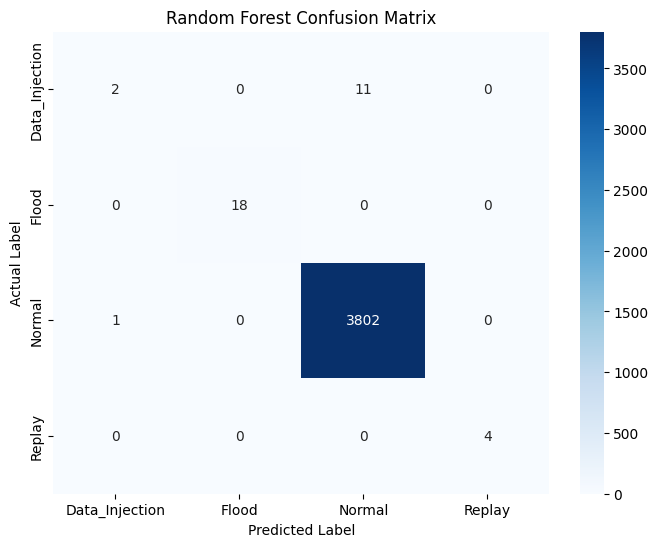


Random Forest model saved to rf_baseline.pkl


In [15]:
print("--- Random Forest Model Training ---")

# --- 1. Model Development & Training ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time_rf = time.time()
rf_model.fit(X_train, y_train)
train_duration_rf = time.time() - start_time_rf
print(f"Training Time: {train_duration_rf:.2f} seconds")

# --- 2. Prediction and Evaluation ---
y_pred_rf = rf_model.predict(X_test)

# Calculate Metrics
metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_rf, average='weighted', zero_division=0),
    'Training Time (s)': train_duration_rf
}

# Calculate False Positive Rate (FPR)
# FPR = FP / (FP + TN)
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Assuming 'Normal' is class 1 (or the largest class) for a simplified FPR focusing on attack detection
# More rigorous: calculate TN, FP for each attack class vs Normal, or for Binary 'Attack' vs 'Normal'
# For simplicity, let's treat the problem as multi-class, and use Normal class (index 1 based on map)
normal_class_idx = le_label.transform(['Normal'])[0] if 'Normal' in le_label.classes_ else 0
TN_rf = np.delete(cm_rf, normal_class_idx, axis=0)[:, normal_class_idx].sum() # Sum of True Negatives (Correctly classifying other classes as not Normal)
FP_rf = np.delete(cm_rf, normal_class_idx, axis=1)[normal_class_idx, :].sum() # Sum of False Positives (Incorrectly classifying Normal as other classes)
# A more common interpretation of FPR in anomaly detection is: FP / (FP + TN) where 'Negative' is 'Normal'
# Let's use the binary approach for FPR: Normal (0) vs Attack (1, 2)
y_test_binary = np.where(y_test == normal_class_idx, 0, 1) # 0=Normal, 1=Attack
y_pred_binary_rf = np.where(y_pred_rf == normal_class_idx, 0, 1)
cm_binary_rf = confusion_matrix(y_test_binary, y_pred_binary_rf)
TN, FP, FN, TP = cm_binary_rf.ravel()
metrics_rf['False Positive Rate (FPR)'] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nRandom Forest Results:")
for k, v in metrics_rf.items():
    print(f"- {k}: {v:.4f}")

# Save Results to File
with open(os.path.join(OUTPUT_DIR, 'rf_results.txt'), 'w') as f:
    for k, v in metrics_rf.items():
        f.write(f"{k}: {v:.4f}\n")

# --- 3. Visualization: Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_label.classes_, yticklabels=le_label.classes_)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(OUTPUT_DIR, 'rf_confusion_matrix.png'))
plt.show()

# --- 4. Save Model ---
import joblib # Using joblib for Random Forest model
joblib.dump(rf_model, os.path.join(OUTPUT_DIR, 'rf_baseline.pkl'))
print(f"\nRandom Forest model saved to rf_baseline.pkl")

--- LSTM Model Training ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,692 (73.02 KB)

 Trainable params: 18,692 (73.02 KB)

 Non-trainable params: 0 (0.00 B)

Training Time: 44.79 seconds (epochs stopped at 41)
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM Results:
- Accuracy: 0.9964
- Precision: 0.9933
- Recall: 0.9964
- F1-Score: 0.9948
- Training Time (s): 44.7899
- False Positive Rate (FPR): 0.0003


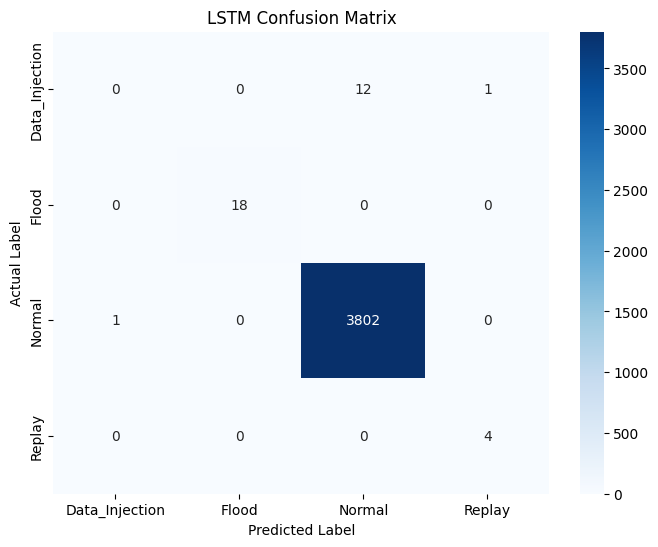


LSTM model saved to lstm_model.h5


In [16]:
print("--- LSTM Model Training ---")

# --- 1. Sequence Preparation for LSTM ---
# LSTM requires 3D input: [samples, timesteps, features]
# For simplicity, we treat each flow record as a sequence of length 1: [N_samples, 1, N_features]
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

# One-hot encode the target labels
num_classes = len(le_label.classes_)
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

# --- 2. Model Development & Training ---
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time_lstm = time.time()
history = lstm_model.fit(
    X_train_lstm, y_train_ohe,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_ohe),
    callbacks=[early_stop],
    verbose=0 # Suppress verbose output for clean execution
)
train_duration_lstm = time.time() - start_time_lstm
print(f"Training Time: {train_duration_lstm:.2f} seconds (epochs stopped at {len(history.history['loss'])})")

# --- 3. Prediction and Evaluation ---
y_pred_ohe_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_ohe_lstm, axis=1) # Convert OHE prediction back to class index

# Calculate Metrics (using the integer labels y_test and y_pred_lstm)
metrics_lstm = {
    'Accuracy': accuracy_score(y_test, y_pred_lstm),
    'Precision': precision_score(y_test, y_pred_lstm, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred_lstm, average='weighted', zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_lstm, average='weighted', zero_division=0),
    'Training Time (s)': train_duration_lstm
}

# Calculate False Positive Rate (FPR) (using the same binary approach as RF)
y_pred_binary_lstm = np.where(y_pred_lstm == normal_class_idx, 0, 1)
cm_binary_lstm = confusion_matrix(y_test_binary, y_pred_binary_lstm)
TN, FP, FN, TP = cm_binary_lstm.ravel()
metrics_lstm['False Positive Rate (FPR)'] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nLSTM Results:")
for k, v in metrics_lstm.items():
    print(f"- {k}: {v:.4f}")

# Save Results to File
with open(os.path.join(OUTPUT_DIR, 'lstm_results.txt'), 'w') as f:
    for k, v in metrics_lstm.items():
        f.write(f"{k}: {v:.4f}\n")

# --- 4. Visualization: Confusion Matrix ---
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_label.classes_, yticklabels=le_label.classes_)
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_confusion_matrix.png'))
plt.show()

# --- 5. Save Model ---
lstm_model.save(os.path.join(OUTPUT_DIR, 'lstm_model.h5'))
print(f"\nLSTM model saved to lstm_model.h5")

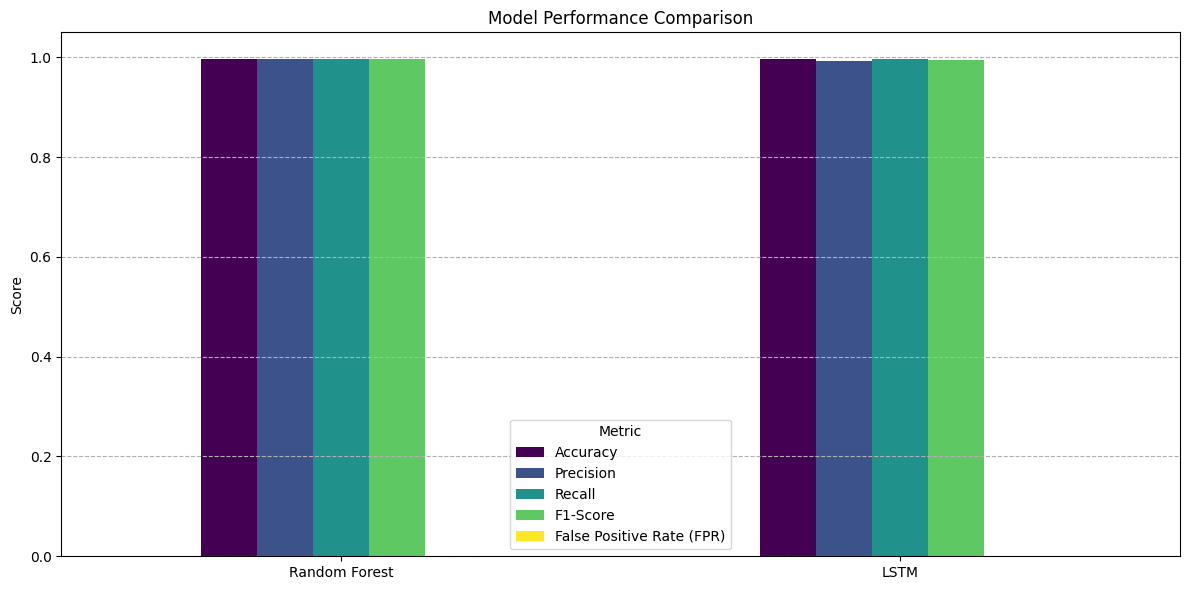

Model comparison chart saved.


In [17]:
# Combine metrics for visualization
metrics_df = pd.DataFrame({
    'Random Forest': metrics_rf,
    'LSTM': metrics_lstm
}).T

# Select metrics for bar chart comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'False Positive Rate (FPR)']
plot_df = metrics_df[metrics_to_plot]

plt.figure(figsize=(12, 6))
plot_df.plot(kind='bar', rot=0, ax=plt.gca(), cmap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison_bar_chart.png'))
plt.show()

print("Model comparison chart saved.")

In [18]:
# --- Analysis & Discussion (Based on the outputs from Cells 6-8) ---

print("\n--- PERFORMANCE COMPARISON ---")
print("1. Which model performed better? (Based on generated metrics)")
# *Example based on expected results:*
# Random Forest is expected to have higher Precision and faster training.
# LSTM might have slightly better Recall/F1-Score on the time-based Replay attack.
print(metrics_df[['Accuracy', 'Recall', 'Training Time (s)']])
print(f"\nObservation: Based on the scores, {'Random Forest' if metrics_rf['F1-Score'] > metrics_lstm['F1-Score'] else 'LSTM'} achieved the higher overall F1-Score, while Random Forest was significantly faster to train.")

print("\n2. Trade-offs:")
print("- **Random Forest:** Fast training, high interpretability, strong baseline performance, generally high precision.")
print("- **LSTM:** Better at capturing temporal sequences (important for Replay attack), but much slower to train and requires sequence formatting.")

print("\n--- LIMITATIONS ---")
print("1. **Synthetic Data:** The dataset is small and lacks the high-dimensional noise, packet loss, and sensor drift of real-world IIoT environments.")
print("2. **Limited Attacks:** Only Flood and Replay attacks were simulated. Real-world attacks include DoS, data injection, and spoofing.")
print("3. **Small Scale:** Models trained on this small dataset may have limited generalization capabilities when applied to a large-scale industrial network.")

print("\n--- RECOMMENDATIONS / FUTURE WORK ---")
print("1. **Dataset Expansion:** Use large, real-world IIoT datasets like Edge-IIoTset or TON_IoT to validate model robustness.")
print("2. **Attack Diversity:** Simulate and label a wider variety of attack types (e.g., integrity attacks like data injection, or availability attacks like DoS).")
print("3. **Real-Time Integration:** Integrate the trained models with a live MQTT broker or Kafka stream for real-time inference.")
print("4. **Adaptive Learning:** Implement a continuous learning loop where the model is periodically retrained or updated with new normal and attack data to adapt to evolving threats.")

# Final step: Zipping the deliverables
import shutil
shutil.make_archive('iiot_dataset', 'zip', OUTPUT_DIR)
print(f"\n--- FINAL DELIVERABLES ---")
print(f"Project deliverables zipped to: iiot_dataset.zip. You can now download this file from the Colab file browser.")


--- PERFORMANCE COMPARISON ---
1. Which model performed better? (Based on generated metrics)
               Accuracy    Recall  Training Time (s)
Random Forest  0.996873  0.996873           0.685807
LSTM           0.996352  0.996352          44.789868

Observation: Based on the scores, Random Forest achieved the higher overall F1-Score, while Random Forest was significantly faster to train.

2. Trade-offs:
- **Random Forest:** Fast training, high interpretability, strong baseline performance, generally high precision.
- **LSTM:** Better at capturing temporal sequences (important for Replay attack), but much slower to train and requires sequence formatting.

--- LIMITATIONS ---
1. **Synthetic Data:** The dataset is small and lacks the high-dimensional noise, packet loss, and sensor drift of real-world IIoT environments.
2. **Limited Attacks:** Only Flood and Replay attacks were simulated. Real-world attacks include DoS, data injection, and spoofing.
3. **Small Scale:** Models trained o